In [90]:
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

In [91]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)

In [92]:
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 10), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 10))

In [93]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [94]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [95]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

2022-08-07 13:52:13.812977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


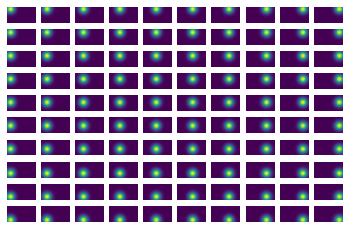

In [96]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

(150, 100)


2022-08-07 13:52:16.372768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='time'>

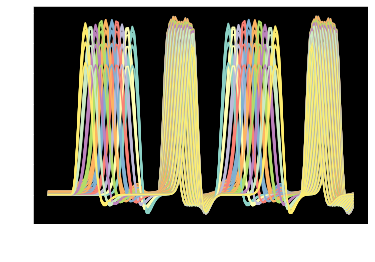

In [97]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

(1, 150, 100)


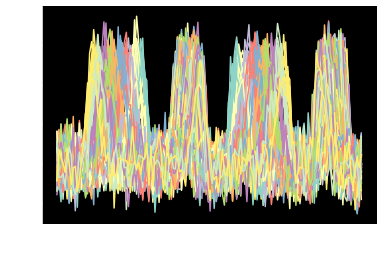

In [98]:
data = model.simulate(noise=35)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [99]:
from braincoder.optimize import ParameterFitter

In [100]:
fitter = ParameterFitter(model, data, paradigm)

In [101]:
grid_pars = fitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)

Working with chunk size of 44444
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


In [102]:
grid_pars

,x,y,sd,baseline,amplitude
0,-0.789474,-0.444079,0.23,0.0,1.0
1,-0.578947,-0.444079,0.23,0.0,1.0
2,-0.368421,-0.444079,0.23,0.0,1.0
3,-0.263158,-0.444079,0.23,0.0,1.0
4,-0.052632,-0.444079,0.23,0.0,1.0
...,...,...,...,...,...
95,0.052632,0.444079,0.23,0.0,1.0
96,0.263158,0.444079,0.23,0.0,1.0
97,0.473684,0.444079,0.23,0.0,1.0
98,0.578947,0.444079,0.23,0.0,1.0


In [103]:
ols_pars = fitter.refine_baseline_and_amplitude(grid_pars)

(150, 100)
Original mean r2: -1652765.0
(150, 100)
100.00% of time lines improved
(150, 100)
New mean r2 after OLS: 0.8508486747741699
(150, 100)
Original mean r2: 0.8508486747741699
(150, 100)
8.00% of time lines improved
(150, 100)
New mean r2 after OLS: 0.8508486747741699


In [104]:
ols_pars

,x,y,sd,baseline,amplitude
0,-0.789474,-0.444079,0.23,-2.747063,0.000868
1,-0.578947,-0.444079,0.23,0.628638,0.000913
2,-0.368421,-0.444079,0.23,2.462127,0.000885
3,-0.263158,-0.444079,0.23,-6.519174,0.000887
4,-0.052632,-0.444079,0.23,-1.060383,0.000898
...,...,...,...,...,...
95,0.052632,0.444079,0.23,-4.713048,0.000879
96,0.263158,0.444079,0.23,-3.037768,0.000825
97,0.473684,0.444079,0.23,1.561415,0.000847
98,0.578947,0.444079,0.23,-2.568625,0.000877


In [105]:
refined_pars = fitter.fit(init_pars=ols_pars, learning_rate=0.001)

2022-08-07 13:52:17.535984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


  0%|          | 0/1000 [00:00<?, ?it/s]2022-08-07 13:52:17.623401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 13:52:17.886711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 13:52:18.106663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 13:52:18.221841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Current R2: 0.86284/Best R2: 0.86284: 100%|██████████| 1000/1000 [00:19<00:00, 51.07it/s]


(150, 100)


In [106]:
refined_pars

parameter,x,y,sd,baseline,amplitude
0,-0.749222,-0.426584,0.191362,-2.547700,0.001003
1,-0.583854,-0.440502,0.214608,0.800336,0.000991
2,-0.419677,-0.417225,0.212270,2.571399,0.000948
3,-0.264560,-0.394440,0.209316,-6.451515,0.000930
4,-0.084117,-0.418803,0.214950,-0.971641,0.000944
...,...,...,...,...,...
95,0.059435,0.406909,0.217544,-4.733184,0.000890
96,0.261373,0.440044,0.203089,-2.735514,0.000972
97,0.440975,0.396612,0.194866,1.731153,0.000979
98,0.577017,0.450261,0.212877,-2.359183,0.000978


In [107]:
r2 = fitter.get_rsq(refined_pars)
r2

(150, 100)


0     0.811108
1     0.843161
2     0.863591
3     0.848866
4     0.852188
        ...   
95    0.843821
96    0.830323
97    0.803734
98    0.825729
99    0.804358
Length: 100, dtype: float32

# Mexican hat model

In [108]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [109]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0,
               'srf_amplitude':.6, 
               'srf_factor':2.}).astype(np.float32)

In [110]:
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))

In [111]:
pred_dog = model_dog.predict()

(150, 100)


2022-08-07 13:52:42.284004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='time'>

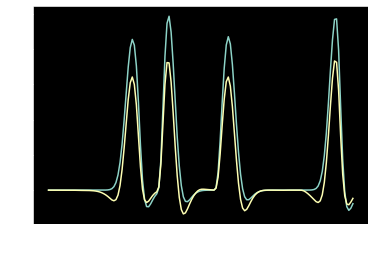

In [112]:
pred[0].plot()
pred_dog[0].plot()

In [113]:
data_dog = model.simulate(noise=35)
# data_dog.plot(legend=False)
# sns.despine()

(1, 150, 100)


In [114]:
fitter = ParameterFitter(model_dog, data_dog, paradigm)

In [115]:
est_pars_dog = refined_pars.copy()
est_pars_dog['srf_amplitude'] = 0.1
est_pars_dog['srf_factor'] = 2.

In [117]:
est_pars_dog = fitter.fit(init_pars=est_pars_dog, learning_rate=0.0001)

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


  0%|          | 0/1000 [00:00<?, ?it/s]2022-08-07 17:20:27.406134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 17:20:27.654540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Current R2: 0.86004/Best R2: 0.86004: 100%|██████████| 1000/1000 [00:24<00:00, 40.10it/s]


(150, 100)


In [ ]:
est_pred = model.predict(parameters=est_pars_dog)

(150, 9)


<AxesSubplot:xlabel='time'>

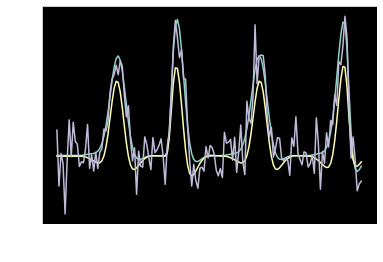

In [ ]:
est_pred[1].plot()
pred_dog[1].plot()
data_dog[1].plot()

In [ ]:
est_pars_dog

parameter,x,y,sd,baseline,amplitude,srf_amplitude,srf_factor
0,-0.745028,-0.459725,0.211555,0.099795,0.001137,0.094779,1.911711
1,-0.024051,-0.422085,0.228091,0.626893,0.000893,0.107753,2.089021
2,0.734511,-0.418576,0.198437,6.366241,0.000929,0.107379,1.945153
3,-0.758322,0.004819,0.201838,-3.933582,0.001051,0.100783,1.941399
4,-0.019413,-0.002598,0.208701,1.935921,0.000973,0.107383,2.042043
5,0.760697,-0.010296,0.214732,2.442059,0.000932,0.090764,1.994269
6,-0.764183,0.413005,0.209513,-1.005643,0.000987,0.120091,2.053754
7,-0.007108,0.440024,0.210823,-3.050919,0.001066,0.097480,1.928474
8,0.740210,0.434164,0.200262,-0.149439,0.001057,0.107476,1.914019


In [ ]:
parameters_dog

,x,y,sd,amplitude,baseline,srf_amplitude,srf_factor
0,-0.75,-0.421875,0.2,0.001,0.0,0.6,2.0
1,0.00,-0.421875,0.2,0.001,0.0,0.6,2.0
2,0.75,-0.421875,0.2,0.001,0.0,0.6,2.0
3,-0.75,0.000000,0.2,0.001,0.0,0.6,2.0
4,0.00,0.000000,0.2,0.001,0.0,0.6,2.0
5,0.75,0.000000,0.2,0.001,0.0,0.6,2.0
6,-0.75,0.421875,0.2,0.001,0.0,0.6,2.0
7,0.00,0.421875,0.2,0.001,0.0,0.6,2.0
8,0.75,0.421875,0.2,0.001,0.0,0.6,2.0


In [ ]:
r2 = fitter.get_rsq()

(150, 9)


In [ ]:
r2

0    0.848944
1    0.832466
2    0.778550
3    0.879281
4    0.876616
5    0.839316
6    0.845879
7    0.822101
8    0.813291
dtype: float32

# CSS model

from braincoder.models import CSSGaussianPRF2DWithHRF

parameters_css = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0,
               'exponent':.6}).astype(np.float32)